/home/aiqing/anaconda3/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-09 10:19:30.920870: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.7 which is older than the PTX compiler version (12.8.61). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


44.694893
44.365776
44.25407
[[0.63852537 0.         0.        ]
 [0.         0.25471103 0.        ]
 [0.         0.         1.9648107 ]]
[[0.20385733 0.         0.        ]
 [0.         0.03243885 0.        ]
 [0.         0.         1.9302406 ]]


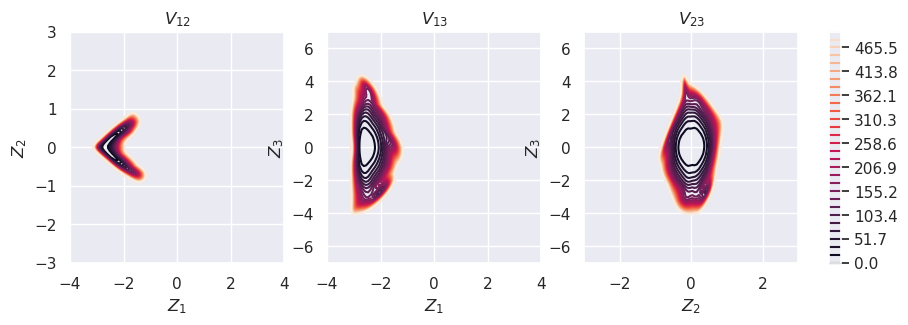

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme() 
from omegaconf import OmegaConf
from utils_reduced_polymer import PlotV

import jax.numpy as jnp
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
def PlotV(net, config):
    # [-2.80463719 -1.9168483  -8.72728634] [1.23797143 1.91939402 8.81887722]
    z1_min, z1_max = -3, 2
    z2_min, z2_max = -3, 3
    z3_min, z3_max = -9, 9 
    z1_min, z1_max = -3, 3
    z2_min, z2_max = -2, 2
    z3_min, z3_max = -6, 6

    num_samples_aux_dimension = 128
    def V(z1, z2, z3):
        z = jnp.array([z1, z2, z3])
        return net.potential(z, [config.temperature]) 
    
    @jax.vmap
    @jax.jit
    def V_12(z1, z2):
        # z3_min, z3_max = -0.1, 0.1
        z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, None, 0))(z1, z2, z3_test_range)) 

    @jax.vmap
    @jax.jit
    def V_13(z1, z3):
        z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (None, 0, None))(z1, z2_test_range, z3)) 

    @jax.vmap
    @jax.jit
    def V_23(z2, z3):
        z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
        return jnp.min(jax.vmap(V, (0, None, None))(z1_test_range, z2, z3)) 
    num_grid = 100
    num_levels = 30
    off_set = 1
    level_start = 0
    level_end = 500.0

    custom_levels =  jnp.linspace(level_start, level_end, num_levels)
    # custom_levels=None

    # Define the range and number of points in each dimension
    z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
    z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
    z3_range = jnp.linspace(z3_min - off_set, z3_max + off_set, num_grid)

    fig, ax = plt.subplots(1, 3, figsize=(10,3)) 
    # V12
    Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
    V12_grid = V_12(Z1.ravel(), Z2.ravel()).reshape(Z1.shape)
    V12_0 = jnp.min(V12_grid)
    print(V12_0)
    contour1 = ax[0].contour(Z1, Z2, V12_grid- V12_0, levels=custom_levels)
    ax[0].set_title(r'$V_{12}$')
    ax[0].set_xlabel(r'$Z_1$')
    ax[0].set_ylabel(r'$Z_2$')

    # V13
    Z1, Z3 = jnp.meshgrid(z1_range, z3_range)
    V13_grid = V_13(Z1.ravel(), Z3.ravel()).reshape(Z1.shape)
    V13_0 = jnp.min(V13_grid)
    print(V13_0)
    contour2 = ax[1].contour(Z1, Z3, V13_grid- V13_0, levels=custom_levels)
    ax[1].set_title(r'$V_{13}$')
    ax[1].set_xlabel(r'$Z_1$')
    ax[1].set_ylabel(r'$Z_3$')

    # V23
    Z2, Z3 = jnp.meshgrid(z2_range, z3_range)
    V23_grid = V_23(Z2.ravel(), Z3.ravel()).reshape(Z1.shape)
    V23_0 = jnp.min(V23_grid)
    print(V23_0)
    contour3 = ax[2].contour(Z2, Z3, V23_grid- V23_0, levels=custom_levels)
    ax[2].set_title(r'$V_{23}$')
    ax[2].set_xlabel(r'$Z_2$')
    ax[2].set_ylabel(r'$Z_3$')

    cbar = fig.colorbar(contour3, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

from utils_reduced_polymer import build_OnsagerNetHD2_scale, build_OnsagerNet #, PlotV
path =  "outputs/main12_HD2" 

config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
model_template = build_OnsagerNetHD2_scale(config)   
# 读取 JAX 神经网络模型 
net = eqx.tree_deserialise_leaves(os.path.join(path,'F1_62_T10/model.eqx'), model_template)
PlotV(net, config)
print(net.diffusion(t=0, x= jnp.array([0.,0.,1.,]), args=[1]))
print(net.dissipation(x= jnp.array([1.,0.,1.,]))) 


In [5]:
from utils_reduced_polymer import entropy_production_polymer

print(entropy_production_polymer(net, 1)[0])

112.544205


In [2]:
import jax.random as jr 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import os  
 

from examples.utils.sde import SDEIntegrator

import os
import pickle

# def PlotTraj(net, config, dataset_name="F23_10_T1"): 

def entropy_production_polymer(net, temperature=1):
    z1_min, z1_max = -3, 3
    z2_min, z2_max = -2, 2
    z3_min, z3_max = -6, 6

    init_unit = jr.uniform(
        key=jr.PRNGKey(123), shape=(1000,3)
    )
    bounds = jnp.array([[z1_min, z1_max],[z2_min, z2_max],[z3_min, z3_max]])
    init_conditions = bounds[:, 0] + (bounds[:, 1] - bounds[:, 0]) * init_unit 

    integrator = SDEIntegrator(model=net, state_dim=3)
    key = jr.PRNGKey(0) 
    bm_keys = jr.split(key, 1000) 
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=1,
        dt=0.0001,
        args=[temperature],
    )
    predicted_trajectories = sol.ys

    def gamma_net(net):
        def gamma(x):
            args=[1]  
            dvdx = jax.grad(net.potential, argnums=0)(x, args)

            #compution of the gamma term
            H = net.Hamiltonian(x)
            grad_H = jax.jacfwd(net.Hamiltonian, argnums=0)(x)
            gamma_value = jnp.einsum('dab,db->a', net.J, grad_H) - jnp.einsum('d,dab,b->a', H, net.J, dvdx)
            return gamma_value
        return gamma

    def ep_term(gamma, dissipation):
        def ep_term_x(x):
            return gamma(x)@(jnp.linalg.inv(dissipation(x))@gamma(x))
        return ep_term_x

    ep_term = ep_term(gamma_net(net), net.dissipation)
    x= predicted_trajectories[:,-1000:,].reshape(-1,3)
    ep = jax.vmap(ep_term)(x)
    
    return ep.mean(), predicted_trajectories
    print(ep.mean())
ep, _ = entropy_production_polymer(net)
print(ep)

434.2863


59.82022


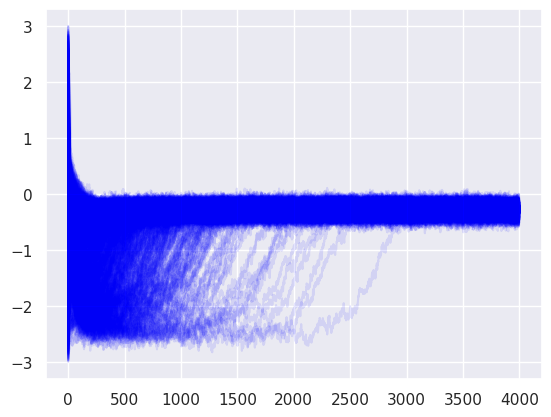

In [27]:
predicted_trajectories = _
for i in range(1000):
    plt.plot(predicted_trajectories[i,:,0], color='blue', alpha=0.1)

print(ep)

TypeError: list indices must be integers or slices, not tuple